In [1]:
import math
from scipy import sparse
from cvxopt import solvers, matrix, spmatrix, mul

import numpy as np
import scipy.linalg as LA
import matplotlib.pyplot as plt

import scienceplots

plt.style.use('science')

import sympy as sp

In [2]:
def fit_J(w, res, expn, etal):
    for i in range(len(etal)):
        res += etal[i] / (expn[i] - 1.j * w)
    return res


def fit_t(t, res, expn, etal):
    for i in range(len(etal)):
        res += etal[i] * np.exp(-expn[i] * t)
    return res


def numpy_to_cvxopt_matrix(A):
    if A is None:
        return A
    if sparse.issparse(A):
        if isinstance(A, sparse.spmatrix):
            return scipy_sparse_to_spmatrix(A)
        else:
            return A
    else:
        if isinstance(A, np.ndarray):
            if A.ndim == 1:
                return matrix(A, (A.shape[0], 1), 'd')
            else:
                return matrix(A, A.shape, 'd')
        else:
            return A

## We are going to decompose a Drude spectrum using prony fitting

In [3]:
# Define the drude spectrum in frequncy domain
def Drude_jw(w, lams=1.0E-4, gams=3):
    return 2.0 * lams * gams * w / (gams**2 + w**2) 

def Ohmic_jw(w, lams=1.0, gams=1.0):
    return w * lams * np.exp(- gams * np.abs(w))

def BO(w, lams=1.0, zeta=1.0, omega_B=1.0):
    return 2.0 * lams * w * omega_B**2 / ((w*zeta)**2 + (w**2 - omega_B**2)**2)

# Drude spectrum in freq-space

/var/folders/65/cm6075cx1h3c4l30_kg5k4zw0000gn/T/ipykernel_52066/3088053403.py:12: RuntimeWarning: invalid value encountered in true_divide
  jw1 = jw  / (1 - np.exp(- beta * w))


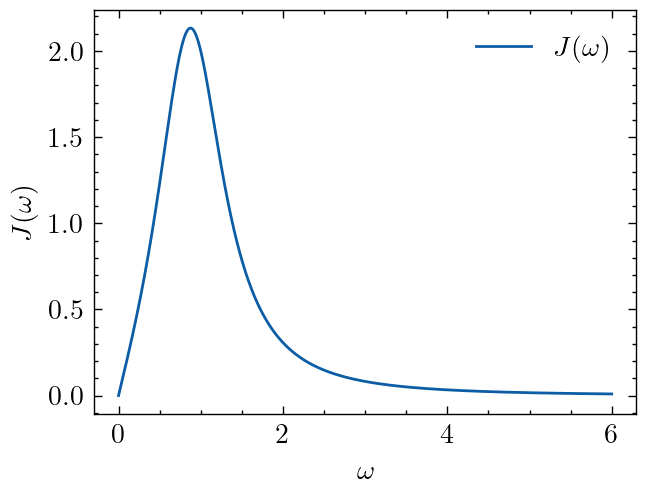

In [5]:
# plot the drude spectral in freq space

beta = 1/10

len_ = 100000
spe_wid = 6
w = np.linspace(-0, spe_wid, len_)

# jw = Drude_jw(w)
# jw = Ohmic_jw(w)
jw = BO(w)
jw1 = jw  / (1 - np.exp(- beta * w))

fig = plt.figure(dpi=200)
ax = fig.gca()
ax.plot(w, jw, label=r"$J(\omega)$")
# ax.plot(w, jw1, label=r"$J(\omega) / (1 - \exp(-\beta  w))$")

ax.set_xlabel(r"$\omega$")
ax.set_ylabel(r"$J(\omega)$")

ax.legend()

# ax.set_xlim(-100, 100)

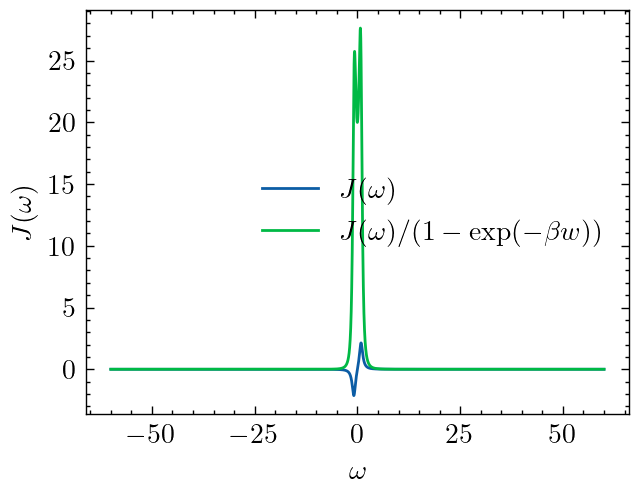

In [54]:
# plot the drude spectral in freq space

beta = 1/10

len_ = 100000
spe_wid = 60
w = np.linspace(-spe_wid, spe_wid, len_)

# jw = Drude_jw(w)
# jw = Ohmic_jw(w)
jw = BO(w)
jw1 = jw  / (1 - np.exp(- beta * w))

fig = plt.figure(dpi=200)
ax = fig.gca()
ax.plot(w, jw, label=r"$J(\omega)$")
ax.plot(w, jw1, label=r"$J(\omega) / (1 - \exp(-\beta  w))$")

ax.set_xlabel(r"$\omega$")
ax.set_ylabel(r"$J(\omega)$")

ax.legend()

# ax.set_xlim(-100, 100)

In [56]:
# fft the drude spectrum to t-space
n = 2000

scale = 200

n_fft = 1000000
scale_fft = 3000
n_rate = (scale_fft * scale/ (4 * n))
n_rate = int(n_rate)

w = np.linspace(0, scale_fft * np.pi, n_fft + 1)[:-1]
dw = w[1] - w[0]

jw = BO(w)
# jw = Drude_jw(w)
# jw = Ohmic_jw(w)
cw1 = jw / (1 - np.exp(-beta * w))
cw2 = jw / (1 - np.exp(+beta * w))
del jw

cw1[0] = cw1[1] / 2
cw2[0] = cw2[1] / 2
fft_ct = (np.fft.fft(cw1) * dw - np.fft.ifft(cw2) * len(cw2) * dw) / np.pi
fft_t = 2 * np.pi * np.fft.fftfreq(len(cw1), dw)
# del cw1, cw2

fft_ct = fft_ct[(scale>=fft_t) & (fft_t >= 0)][::n_rate]
fft_t = fft_t[(scale>=fft_t) & (fft_t >= 0)][::n_rate]

t = fft_t
res_t = np.zeros(len(t), dtype=complex)

/var/folders/65/cm6075cx1h3c4l30_kg5k4zw0000gn/T/ipykernel_52837/279456324.py:17: RuntimeWarning: invalid value encountered in true_divide
  cw1 = jw / (1 - np.exp(-beta * w))
/var/folders/65/cm6075cx1h3c4l30_kg5k4zw0000gn/T/ipykernel_52837/279456324.py:18: RuntimeWarning: overflow encountered in exp
  cw2 = jw / (1 - np.exp(+beta * w))
/var/folders/65/cm6075cx1h3c4l30_kg5k4zw0000gn/T/ipykernel_52837/279456324.py:18: RuntimeWarning: invalid value encountered in true_divide
  cw2 = jw / (1 - np.exp(+beta * w))


Text(0, 0.5, 'C(t)')

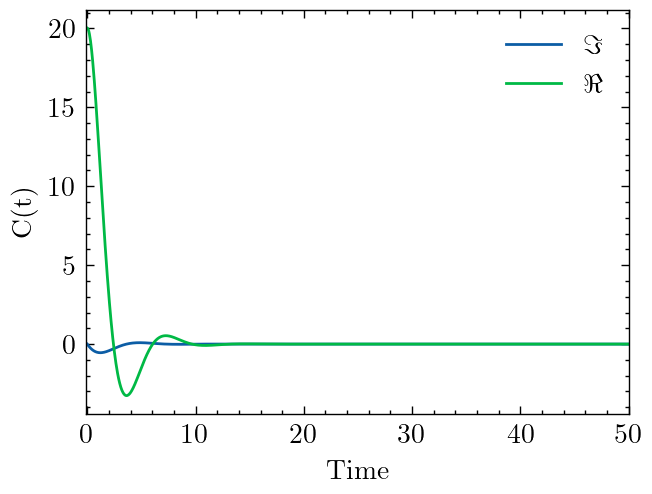

In [57]:
fig = plt.figure(dpi=200)
ax = fig.gca()

ax.plot(fft_t, np.imag(fft_ct), label=r"$\Im$")
ax.plot(fft_t, np.real(fft_ct), label=r"$\Re$")
ax.set_xlim(-0.1, 50)
ax.legend()
ax.set_xlabel("Time")
ax.set_ylabel(r"C(t)")
# print(fft_ct[:10])
# print(fft_ct[-10:])

# Build Hankel matrix

In [58]:
# Sampling 2,000 points and construct Hankel matrix 

res_t = fft_ct.copy()
print(res_t[-10:])

n_sample = n
print(len(t), n_sample)
h = res_t
H_r = np.zeros((n_sample, n_sample))
H_i = np.zeros((n_sample, n_sample))
for i in range(n_sample):
    H_r[i, :] = np.real(h[i:n_sample + i])
    H_i[i, :] = np.imag(h[i:n_sample + i])    

[5.33402805e-06-2.35891139e-15j 5.33402805e-06-2.50910425e-15j
 5.33402805e-06-2.44284269e-15j 5.33402805e-06-2.57536580e-15j
 5.33402805e-06-2.41633807e-15j 5.33402805e-06-2.27939752e-15j
 5.33402805e-06-2.42517294e-15j 5.33402805e-06-2.10711748e-15j
 5.33402805e-06-2.65487967e-15j 5.33402805e-06-2.42517294e-15j]
4001 2000


In [59]:
def Takagi_fact(M_hankel):
    evals, evecs = LA.eigh(M_hankel)

    # construct "phase-decorated" eigen vectors 
    phase_mat = np.diag([np.exp(-1j * np.angle(sing_v_r)/2.0) for sing_v_r in evals])
    Qp = np.matmul(evecs, phase_mat)

    # get the absolute value of eigen values
    abs_evals = np.abs(evals)

    # sorting absevals and Qp according to the absolute eigenvlaues
    argsort = np.flip(np.argsort(abs_evals))

    abs_evals = abs_evals[argsort]
    Qp = Qp[:, argsort]
    return abs_evals, Qp

In [60]:
# Takagi factorization
abs_evals_r, Qp_r = Takagi_fact(H_r)
abs_evals_i, Qp_i = Takagi_fact(H_i)

In [61]:
# estimate decomposition error
print(
    "error of decompose for real part",
    np.sum(
        np.abs(H_r -
               np.matmul(np.matmul(Qp_r, np.diag(abs_evals_r)), (np.transpose(Qp_r))))))
print(abs_evals_r[:10])

print(
    "error of decompose for imaginary part",
    np.sum(
        np.abs(H_i -
               np.dot(np.dot(Qp_i, np.diag(abs_evals_i)), (np.transpose(Qp_i))))))
print(abs_evals_i[:10])

error of decompose for real part 4.303972765290695e-09
[3.35426276e+02 1.25417555e+02 1.04545671e-02 1.74175117e-04
 4.33117194e-08 3.28476741e-12 3.25372400e-12 2.06291343e-12
 1.09601209e-12 1.04561275e-12]
error of decompose for imaginary part 4.66747538895799e-10
[1.63994143e+01 6.40774765e+00 2.54154857e-11 1.28203146e-11
 1.26455698e-11 5.61996631e-12 3.41853734e-12 1.68624129e-12
 1.07352283e-12 9.93042381e-13]


# Prony fitting

In [62]:
def get_gams(Qp, Ki):
    # solve the roots of polynomial f(z):
    gamma = np.roots(np.flip(Qp[:, Ki]))
    argsort = np.argsort(np.abs(gamma))
    gamma_out = gamma[argsort][:Ki]
    return gamma_out

In [63]:
# specify number of gammas
n_gamma_r = 2
n_gamma_i = 2

# get the significant roots of polynomails
gamma_r = get_gams(Qp_r, n_gamma_r)
gamma_i = get_gams(Qp_i, n_gamma_i)

t_r = 2*n*np.log(gamma_r)
t_i = 2*n*np.log(gamma_i)

# calculate exponent of Ki
gamma = np.append(gamma_r, gamma_i)
t = np.append(t_r, t_i)
n_gamma = n_gamma_r + n_gamma_i

In [64]:
n_col = n_sample*2+1
n_row = n_gamma
gamma_m = np.zeros((2 * n_col, 2 * n_row), dtype=float)

for i in range(n_row):
    for j in range(n_col):
        gamma_m[j, i] = np.real(gamma[i]**j)
        gamma_m[n_col + j, n_row + i] = np.real(gamma[i]**j)
        gamma_m[j, n_row + i] = -np.imag(gamma[i]**j)
        gamma_m[n_col + j, i] = np.imag(gamma[i]**j)

h_m = np.append(np.real(h), np.imag(h))

freq_d = np.append(
    np.append(
        np.linspace(-10000, 10, n_col//2), 
        np.linspace(-10, 10, n_col + 1)
        ), 
        np.linspace(10, 10000, n_col//2)
        )

freq_m = np.zeros((2 * n_col, 2 * n_row), dtype=float)
expn = -t / scale
for i in range(n_row):
    for j in range(2 * n_col):
        freq_m[j, i] = np.real(expn[i]) / (np.real(expn[i])**2 + (np.imag(expn[i]) - freq_d[j])**2)
        freq_m[j, n_row + i] = (np.imag(expn[i]) - freq_d[j]) / (np.real(expn[i])**2 + (np.imag(expn[i]) - freq_d[j])**2)

In [65]:
# optimization

C = numpy_to_cvxopt_matrix(gamma_m)
d = numpy_to_cvxopt_matrix(h_m)
A = numpy_to_cvxopt_matrix(-freq_m)
b = numpy_to_cvxopt_matrix(np.zeros(2 * n_col))
Q = C.T * C
q = - d.T * C

opts = {'show_progress': True, 'abstol': 1e-24, 'reltol': 1e-24, 'feastol': 1e-24}
for k, v in opts.items():
    solvers.options[k] = v
sol = solvers.qp(Q, q.T, A, b, None, None, None, None)

omega_new_temp = np.array(sol['x']).reshape(2, n_gamma)
omega_new = omega_new_temp[0,:] + 1.j*omega_new_temp[1,:]
print(omega_new)

etal_p = omega_new
expn_p = -t / scale

etal = omega_new.copy()
etar = np.conjugate(omega_new)
etaa = np.abs(omega_new)
expn = -t / scale

print(etal.shape)

     pcost       dcost       gap    pres   dres
 0: -2.5553e+02 -7.9682e+02  2e+04  9e+01  3e+00
 1: -9.4179e+02 -2.6863e+03  9e+03  5e+01  2e+00
 2: -2.5241e+03 -4.6876e+03  6e+03  3e+01  1e+00
 3: -3.7129e+03 -5.4899e+03  3e+03  1e+01  4e-01
 4: -4.0052e+03 -4.4975e+03  6e+02  1e+00  4e-02
 5: -4.0892e+03 -4.1403e+03  6e+01  3e-02  1e-03
 6: -4.1059e+03 -4.1129e+03  7e+00  8e-04  3e-05
 7: -4.1081e+03 -4.1095e+03  1e+00  9e-05  3e-06
 8: -4.1084e+03 -4.1088e+03  4e-01  2e-05  8e-07
 9: -4.1085e+03 -4.1085e+03  4e-02  1e-07  5e-09
10: -4.1085e+03 -4.1085e+03  2e-03  1e-10  4e-11
11: -4.1085e+03 -4.1085e+03  4e-05  1e-12  3e-11
12: -4.1085e+03 -4.1085e+03  5e-07  1e-13  7e-13
13: -4.1085e+03 -4.1085e+03  5e-09  1e-13  7e-15
14: -4.1085e+03 -4.1085e+03  7e-11  1e-13  1e-16
15: -4.1085e+03 -4.1085e+03  9e-13  1e-13  2e-16
16: -4.1085e+03 -4.1085e+03  9e-15  1e-13  1e-16
17: -4.1085e+03 -4.1085e+03  9e-17  1e-13  2e-16
18: -4.1085e+03 -4.1085e+03  9e-19  1e-13  2e-16
19: -4.1085e+03 -4.10

In [75]:
np.savetxt("expn1_{}".format(len(expn)), expn)
np.savetxt("etal1_{}".format(len(etal)), etal)
np.savetxt("etar1_{}".format(len(etar)), etar)

np.savetxt("expn2_{}".format(len(expn)), expn)
np.savetxt("etal2_{}".format(len(etal)), etal)
np.savetxt("etar2_{}".format(len(etar)), etar)

In [76]:
etaa

array([ 0.28195777,  0.28195548, 11.78752227, 10.79222899])

/var/folders/65/cm6075cx1h3c4l30_kg5k4zw0000gn/T/ipykernel_52837/2734506162.py:18: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(w, phixx / (1 - np.exp(-beta * w)),


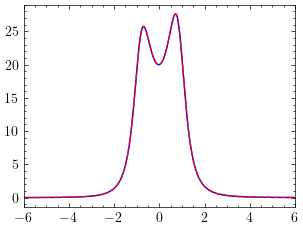

In [70]:
len_ = 10000
spe_wid = 200

w = np.append(np.linspace(-spe_wid, 0, len_),np.linspace(0, spe_wid, len_))

w_sp, lamd_sp, gams_sp, beta_sp = sp.symbols(
    r"\omega , \lambda, \gamma, \beta", real=True)

# phixx = Drude_jw(w) 
phixx = BO(w) 
# phixx = Ohmic_jw(w) 
res_J = np.zeros(len(w),dtype=complex)
fit_J(w, res_J, expn, etal)

plt.plot(w, res_J.real,
            'b',
            label='phixx')
plt.plot(w, phixx / (1 - np.exp(-beta * w)),
            'r--',
            label='phixx')
plt.xlim(-6, 6)
plt.show()

/var/folders/65/cm6075cx1h3c4l30_kg5k4zw0000gn/T/ipykernel_52837/1977383743.py:15: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(w, res_J.real- phixx / (1 - np.exp(-beta * w)),


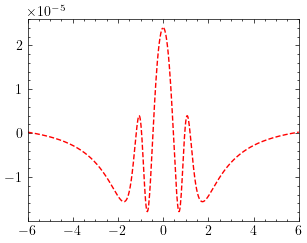

In [71]:
len_ = 10000
spe_wid = 200

w = np.append(np.linspace(-spe_wid, 0, len_),np.linspace(0, spe_wid, len_))

w_sp, lamd_sp, gams_sp, beta_sp = sp.symbols(
    r"\omega , \lambda, \gamma, \beta", real=True)

# phixx = Drude_jw(w) 
phixx = BO(w) 
# phixx = Ohmic_jw(w) 
res_J = np.zeros(len(w),dtype=complex)
fit_J(w, res_J, expn, etal)

plt.plot(w, res_J.real- phixx / (1 - np.exp(-beta * w)),
            'r--',
            label='diff')
plt.xlim(-6, 6)
plt.show()

array([ 0.2770814 -0.05221192j,  0.27708167+0.05219809j,
       10.30858403+5.71653538j,  9.15388376-5.71652155j])

# Decompose any 

In [13]:
from deom.deom import benchmark, convert, decompose_spe

In [14]:
w_sp, lambd_sp, gamma_sp, beta_sp = sp.symbols(
            r"\omega, \lambda, \gamma, \beta", real=True)

lams = 1E-4
gams = 3

spe_vib_sp = 2 * lambd_sp * gamma_sp / (gamma_sp - sp.I * w_sp)
sp_para_dict = {lambd_sp: lams, gamma_sp: gams}

beta = 1

condition_dict = {}
para_dict = {'beta': beta}
npsd = 4
etal, etar, etaa, expn = decompose_spe(spe_vib_sp, w_sp, sp_para_dict, para_dict,
                                        condition_dict, npsd)

In [19]:
def get_fit(T, npsd, lams=1E-4, zeta=1.0, omega_B=3.0):
    len_ = 10000
    spe_wid = 300
    w = np.append(np.linspace(-spe_wid, 0, len_),np.linspace(0, spe_wid, len_))

    # w_sp, lambd_sp, gamma_sp, beta_sp = sp.symbols(
    #         r"\omega, \lambda, \gamma, \beta", real=True)

    # spe_vib_sp = 2 * lambd_sp * gamma_sp / (gamma_sp - sp.I * w_sp)
    # sp_para_dict = {lambd_sp: lams, gamma_sp: gams}

    w_sp, lamd_sp, zeta_sp, omgs_sp, beta_sp = sp.symbols(
        r"\omega , \lambda, \zeta, \Omega_{s}, \beta", real=True)
    spe_vib_sp = 2 * omgs_sp * omgs_sp * lamd_sp / (
        omgs_sp * omgs_sp - w_sp * w_sp - zeta_sp * sp.I * w_sp)
    sp_para_dict = {lamd_sp: lams, omgs_sp: omega_B, zeta_sp: zeta}
    condition_dict = {}
    para_dict = {'beta': 1/T}

    etal, etar, etaa, expn = decompose_spe(spe_vib_sp, w_sp, sp_para_dict, para_dict,
                                                condition_dict, npsd)
    
    res_J = np.zeros(len(w),dtype=complex)
    fit_J(w, res_J, expn, etal)
    
    return w, res_J.real

def get_exact(T, lams=1E-4, zeta=1, omega_B=3):
    len_ = 10000
    spe_wid = 300
    w = np.append(np.linspace(-spe_wid, 0, len_),np.linspace(0, spe_wid, len_))

    jw = BO(w, lams, zeta, omega_B)
    return w, jw / (1 - np.exp(- w / T))

In [38]:
npsd_list

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

/var/folders/65/cm6075cx1h3c4l30_kg5k4zw0000gn/T/ipykernel_52837/3581391076.py:34: RuntimeWarning: invalid value encountered in true_divide
  return w, jw / (1 - np.exp(- w / T))


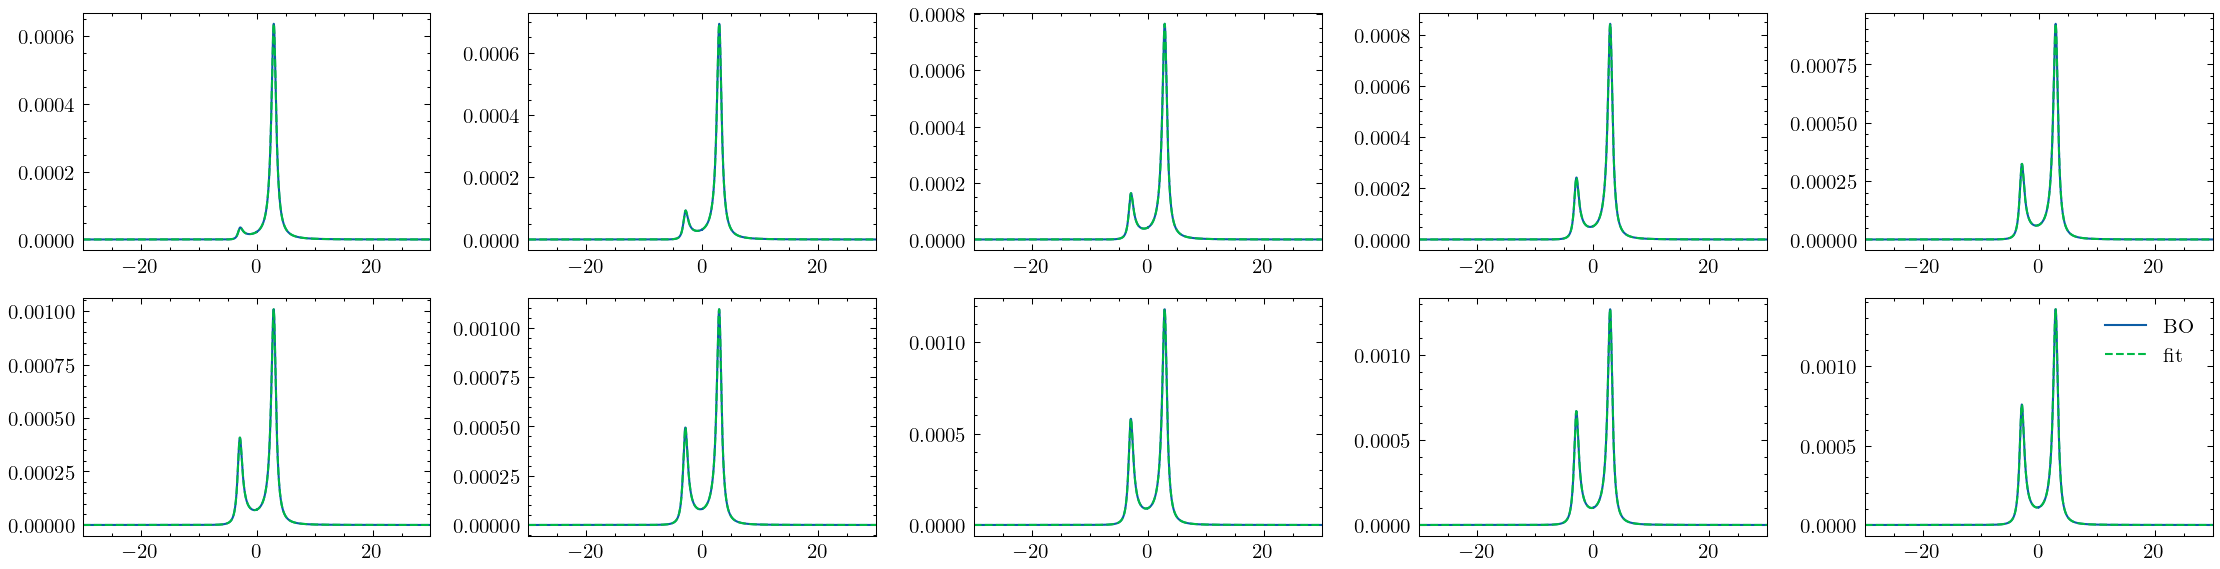

In [48]:
fig = plt.figure(dpi=150, figsize=(3*5, 2*2))
gs = fig.add_gridspec(2, 5)
axs = gs.subplots().flatten()
T_list = np.linspace(1, 5, 10)

npsd_list = np.ones(len(T_list), dtype=int) * 2

for ii, ax in enumerate(axs):
    w, Jw_BO = get_exact(T_list[ii])
    ax.plot(w, Jw_BO, label="BO")

    w, Jw_fit = get_fit(T_list[ii], npsd_list[ii])
    ax.plot(w, Jw_fit, ls='--', label="fit")

    ax.set_xlim(-30, 30)

ax.legend()
fig.tight_layout()

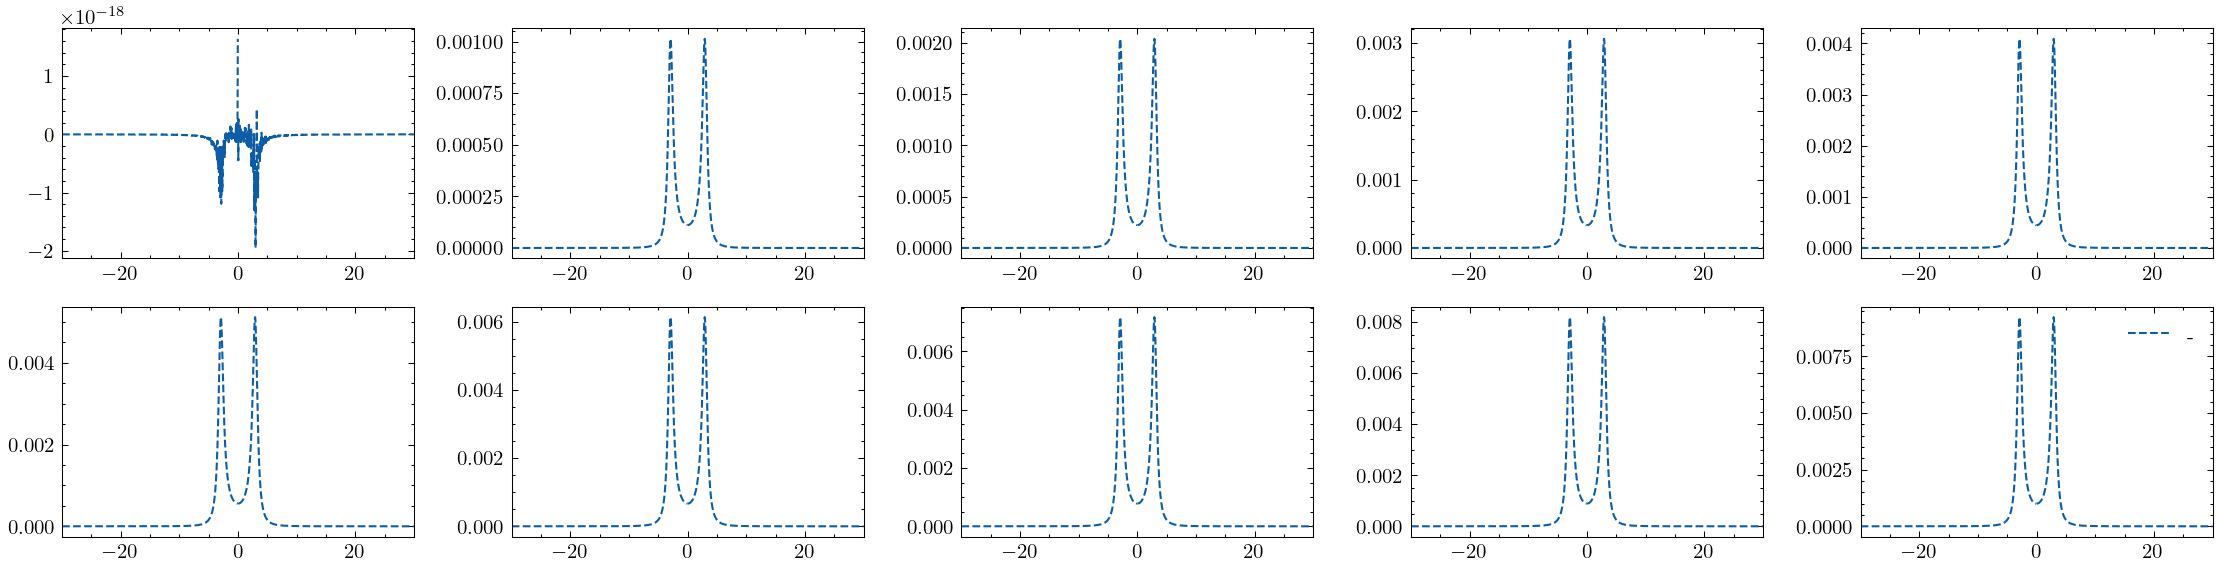

In [47]:
fig = plt.figure(dpi=150, figsize=(3*5, 2*2))
gs = fig.add_gridspec(2, 5)
axs = gs.subplots().flatten()
T_list = np.linspace(5, 50, 10)

npsd_list = np.ones(len(T_list), dtype=int) * 50

for ii, ax in enumerate(axs):
    w, Jw_fit = get_fit(T_list[ii], npsd_list[ii])
    ax.plot(w, Jw_fit - Jw_BO, ls='--', label=" - ")

    ax.set_xlim(-30, 30)

ax.legend()
fig.tight_layout()

/var/folders/65/cm6075cx1h3c4l30_kg5k4zw0000gn/T/ipykernel_7449/45155341.py:29: RuntimeWarning: invalid value encountered in divide
  return w, jw / (1 - np.exp(- w / T))


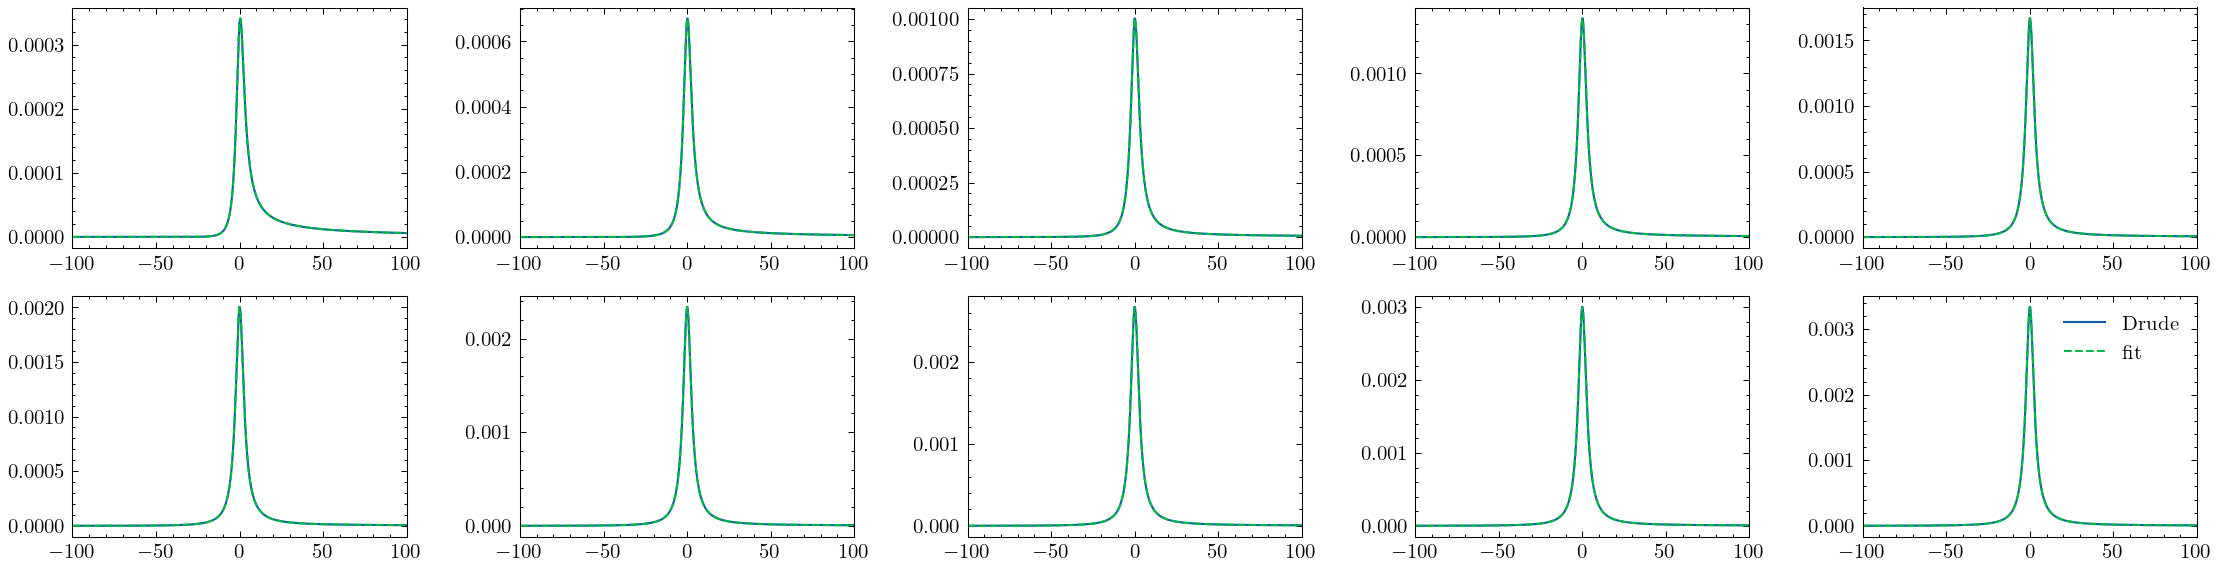

In [22]:
fig = plt.figure(dpi=150, figsize=(3*5, 2*2))
gs = fig.add_gridspec(2, 5)
axs = gs.subplots().flatten()
T_list = np.linspace(5, 50, 10)

npsd_list = np.ones(len(T_list), dtype=int) * 3

for ii, ax in enumerate(axs):
    w, Jw_drude = get_exact(T_list[ii])
    ax.plot(w, Jw_drude, label="Drude")

    w, Jw_fit = get_fit(T_list[ii], npsd_list[ii])
    ax.plot(w, Jw_fit, ls='--', label="fit")

    ax.set_xlim(-100, 100)

ax.legend()
fig.tight_layout()

/var/folders/65/cm6075cx1h3c4l30_kg5k4zw0000gn/T/ipykernel_7449/45155341.py:29: RuntimeWarning: invalid value encountered in divide
  return w, jw / (1 - np.exp(- w / T))


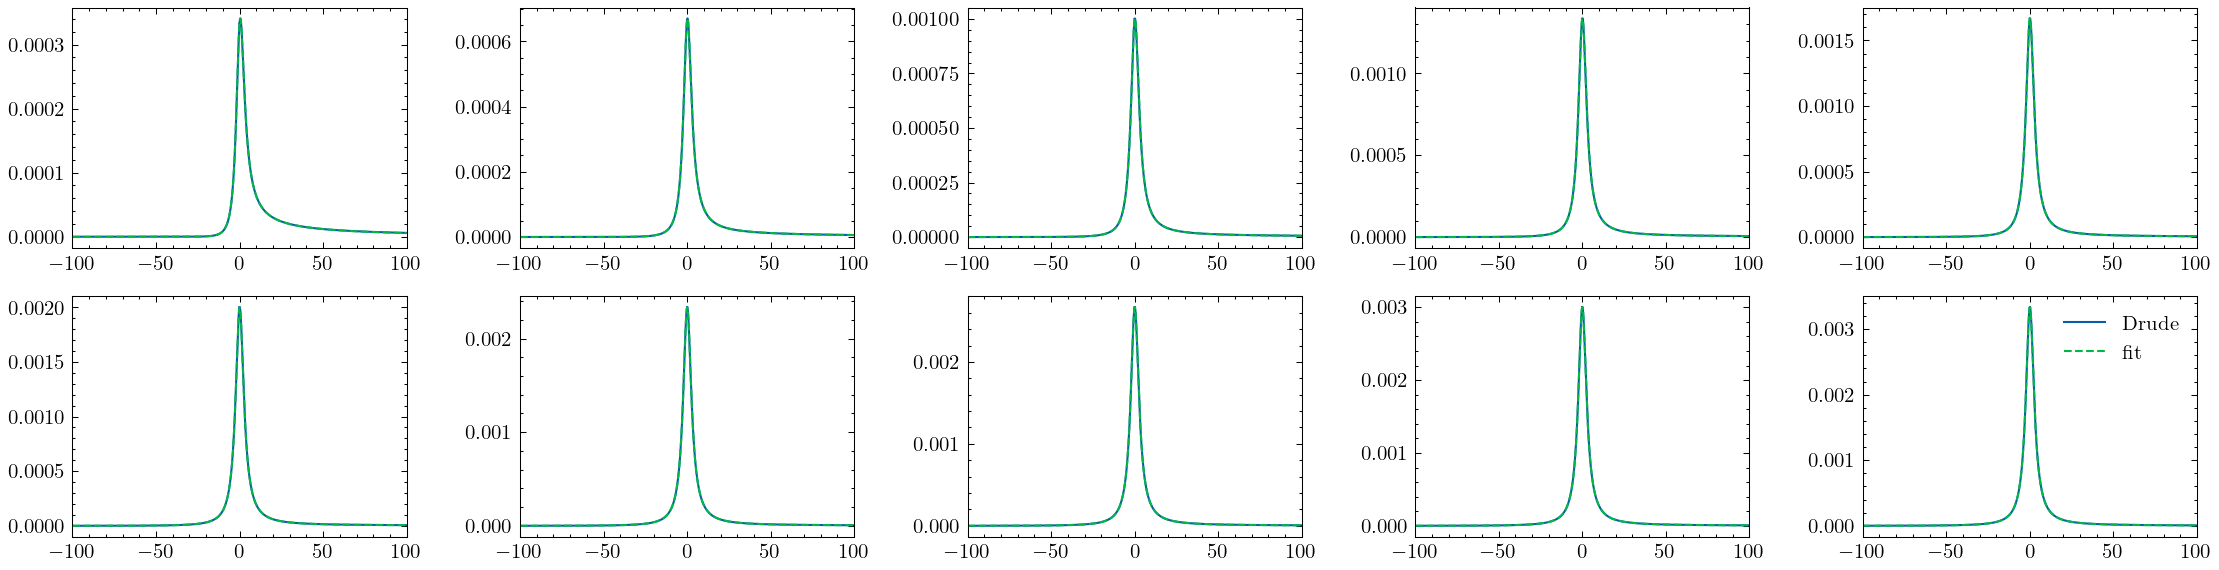

In [25]:
fig = plt.figure(dpi=150, figsize=(3*5, 2*2))
gs = fig.add_gridspec(2, 5)
axs = gs.subplots().flatten()
T_list = np.linspace(5, 50, 10)

npsd_list = np.ones(len(T_list), dtype=int) * 2

for ii, ax in enumerate(axs):
    w, Jw_drude = get_exact(T_list[ii])
    ax.plot(w, Jw_drude, label="Drude")

    w, Jw_fit = get_fit(T_list[ii], npsd_list[ii])
    ax.plot(w, Jw_fit, ls='--', label="fit")

    ax.set_xlim(-100, 100)

ax.legend()
fig.tight_layout()


fig.savefig("Drude-npsd=2.pdf")

/var/folders/65/cm6075cx1h3c4l30_kg5k4zw0000gn/T/ipykernel_7449/45155341.py:29: RuntimeWarning: invalid value encountered in divide
  return w, jw / (1 - np.exp(- w / T))


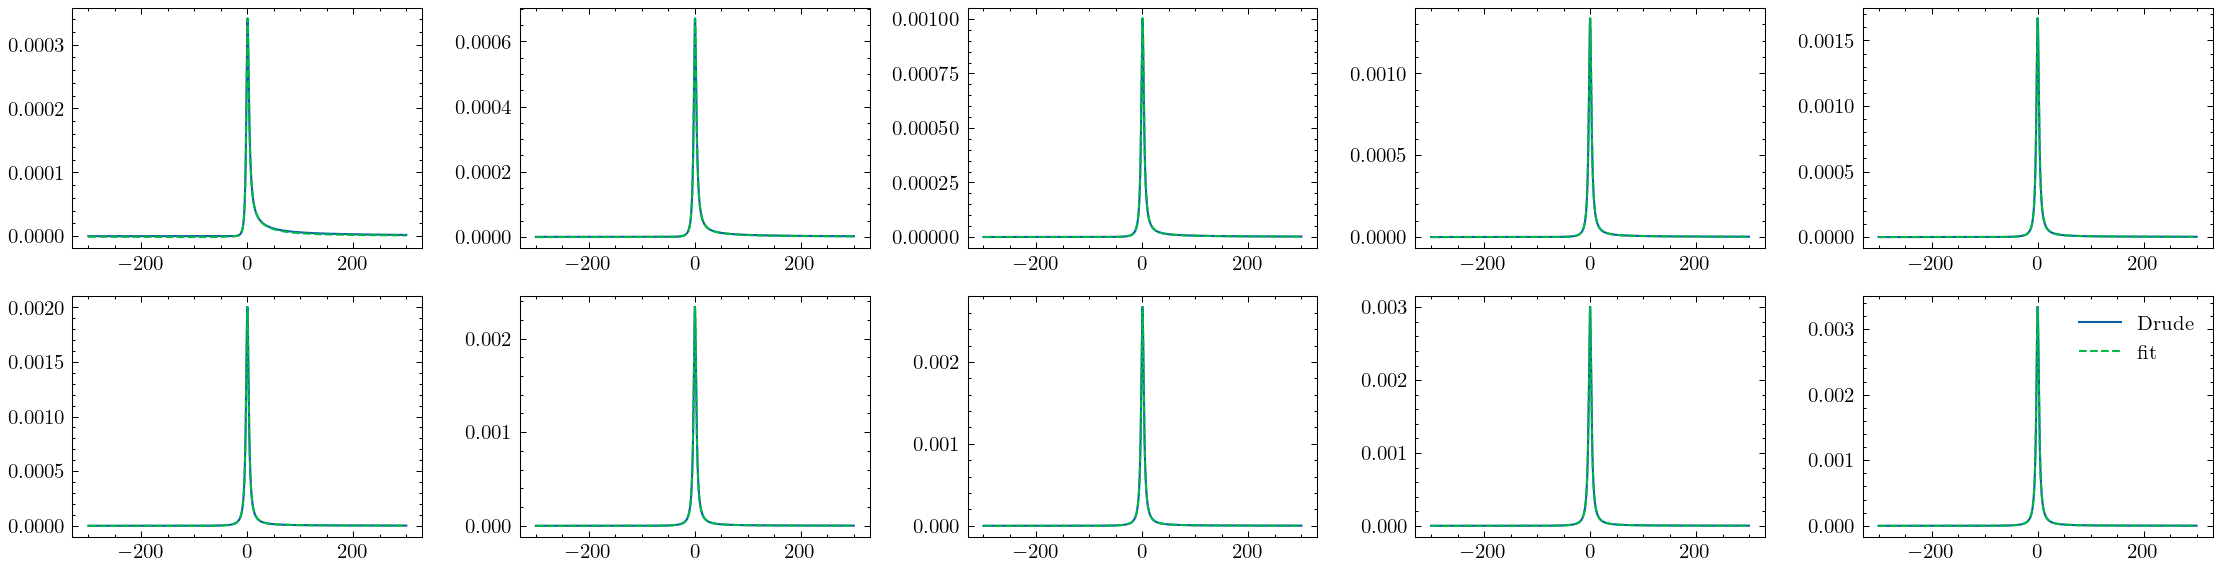

In [24]:
fig = plt.figure(dpi=150, figsize=(3*5, 2*2))
gs = fig.add_gridspec(2, 5)
axs = gs.subplots().flatten()
T_list = np.linspace(5, 50, 10)

npsd_list = np.ones(len(T_list), dtype=int) * 1

for ii, ax in enumerate(axs):
    w, Jw_drude = get_exact(T_list[ii])
    ax.plot(w, Jw_drude, label="Drude")

    w, Jw_fit = get_fit(T_list[ii], npsd_list[ii])
    ax.plot(w, Jw_fit, ls='--', label="fit")

    # ax.set_xlim(-100, 100)

ax.legend()
fig.tight_layout()

fig.savefig("Drude-npsd=1.pdf")